<a href="https://colab.research.google.com/github/Zachary-Fernandes/CSCI-6962/blob/main/fernazHW1v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1
#####Zachary Fernandes
#####Projects in Machine Learning and AI

### The Problem
The machine learning problem I wanted to solve involved the [NASA Nearest Earth Objects dataset](https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects?select=neo_v2.csv) found on Kaggle. The exact problem here is determining whether or not an asteroid is a hazard to humans given the dataset's features - estimated diameter, relative velocity, miss distance, and absolute magnitude.

I wanted to solve this problem with logistic regression. This is the best selection for solving this problem because determining whether or not an asteroid is hazard is a binary classification task. If we used linear regression here, we would get a continuous outcome as a solution. What I want to do, however, requires a categorical, binary output, that being hazardous or non-hazardous. This binary classification is a problem that is appropriate for logistic regression to solve, which is why it is the right tool for this job.

### Setup

In [101]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [102]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

### Exploratory Data Analysis
Below are the steps I take to perform Exploratory Data Analysis.

#### Getting the Data

In [103]:
# data source: https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects
# note: we have combined Training and Testing data from Kaggle into a single data frame
df = pd.read_csv('neo_v2.csv')

Data Dictionary


| **Variable**       | **Definition**                                                |
|--------------------|---------------------------------------------------------------|
| id                 | Unique Identifier for each Asteroid                           |
| name               | Name given by NASA                                            |
| est_diameter_min   | Minimum Estimated Diameter in Kilometres                      |
| est_diameter_max   | Maximum Estimated Diameter in Kilometres                      |
| relative_velocity  | Velocity Relative to Earth in Kmph                            |
| miss_distance      | Distance in Kilometres missed                                 |
| orbiting_body      | Planet that the asteroid orbits                               |
| sentry_object      | Included in sentry - automated collision monitoring system    |
| absolute_magnitude | Describes intrinsic luminosity                                |
| hazardous          | Boolean feature that shows whether asteroid is harmful or not |

### Exploring the Data

In [104]:
# viewing the first few rows of the data
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [105]:
# what's the data size?
df.shape
# there are not many features, but there are plenty of examples

(90836, 10)

In [106]:
# are there any missing values?
df.isna().sum()
# there are no missing values

id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
orbiting_body         0
sentry_object         0
absolute_magnitude    0
hazardous             0
dtype: int64

In [107]:
# general information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


In [108]:
# statistics of the dataset (numeric columns)
df.describe()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,9.083600e+04,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,1.438288e+07,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,2.087202e+07,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,2.000433e+06,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,3.448110e+06,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,3.748362e+06,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,3.884023e+06,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,5.427591e+07,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


In [109]:
# statistics of the dataset (categorical columns - name and orbiting-body)
df.describe(include=['O'])

,name,orbiting_body
count,90836,90836
unique,27423,1
top,469219 Kamo`oalewa (2016 HO3),Earth
freq,43,90836


In [110]:
# is the data imbalanced?
df.hazardous.value_counts(normalize=True) #normalizes the result
# at about 90% false and 10% true, this dataset is imbalanced

False    0.902682
True     0.097318
Name: hazardous, dtype: float64

#### Pairplot

''

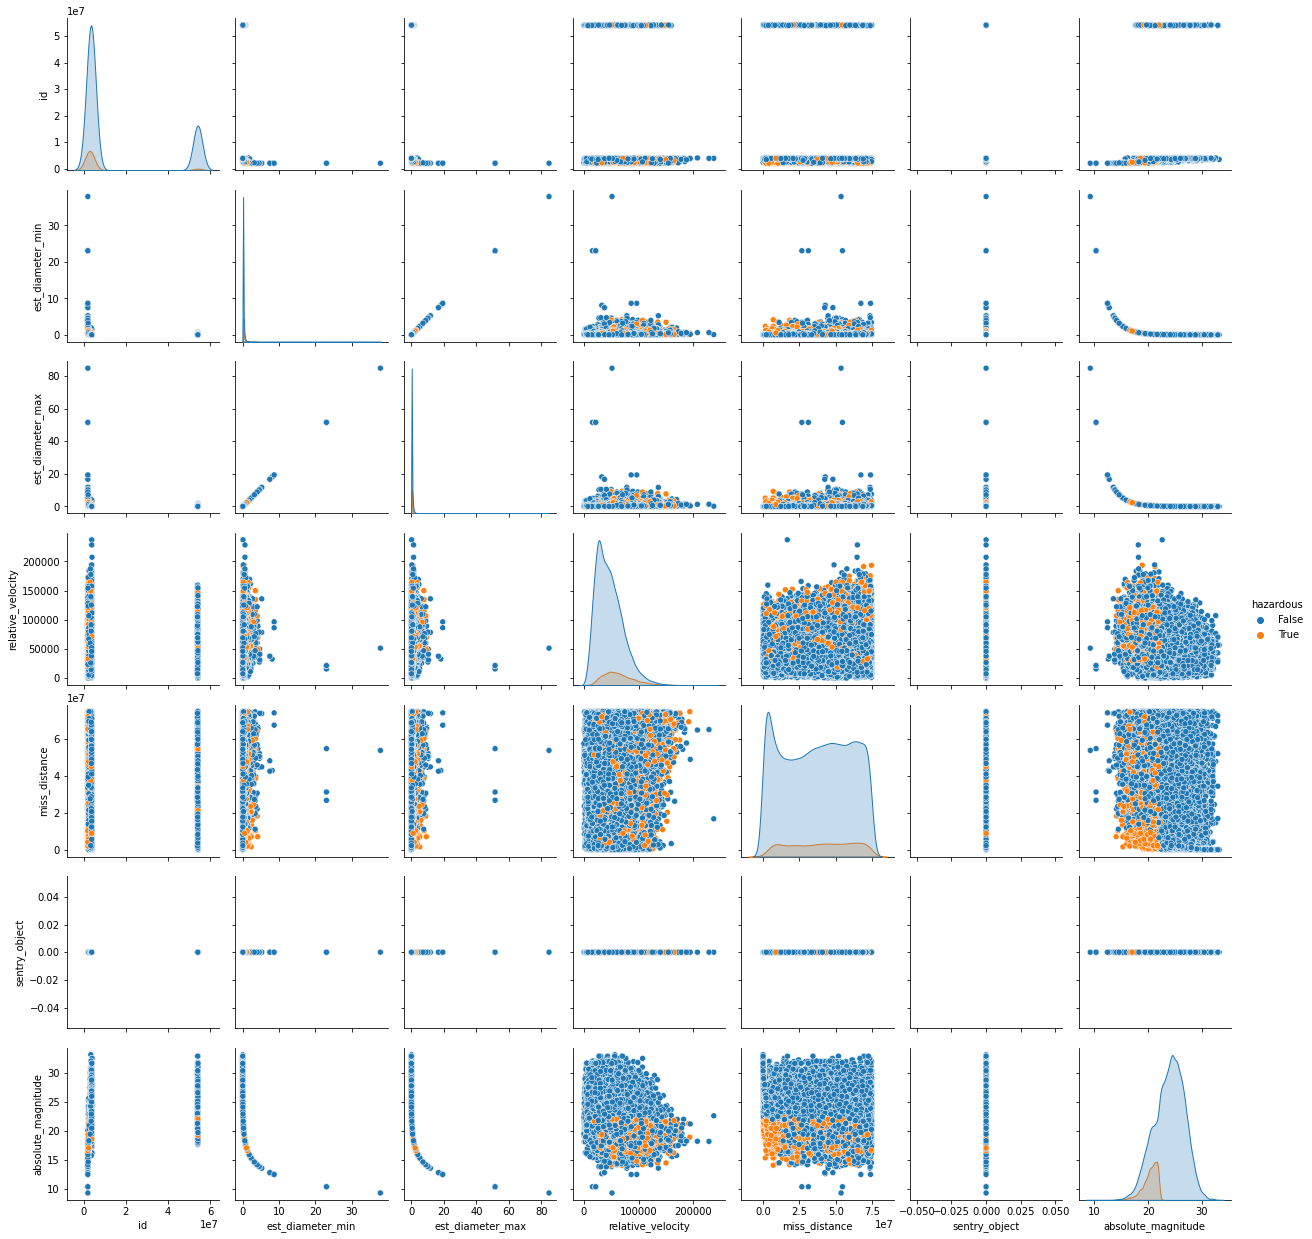

In [ ]:
# ploting pairwise relationships in the dataset
sns.pairplot(df, hue='hazardous')
,

#### Scatter Plot

''

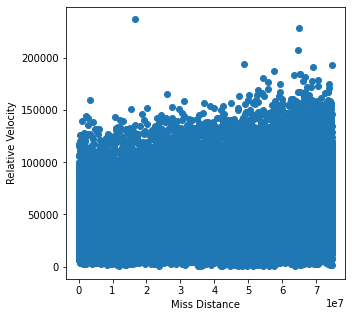

In [111]:
# useful for identifying relationship (i.e. correlation) between two parameters
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(df.miss_distance, df.relative_velocity)
ax.set_xlabel('Miss Distance')
ax.set_ylabel('Relative Velocity')
,

''

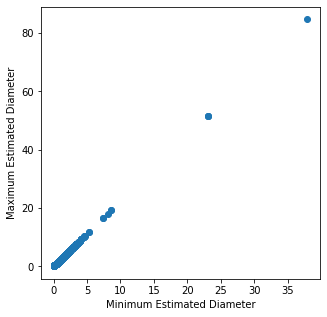

In [112]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(df.est_diameter_min, df.est_diameter_max)
ax.set_xlabel('Minimum Estimated Diameter')
ax.set_ylabel('Maximum Estimated Diameter')
,

''

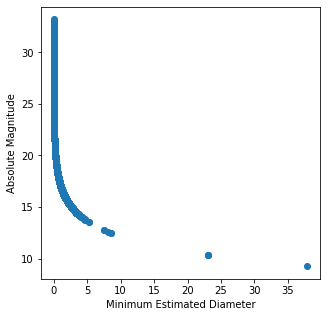

In [113]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(df.est_diameter_min, df.absolute_magnitude)
ax.set_xlabel('Minimum Estimated Diameter')
ax.set_ylabel('Absolute Magnitude')
,

#### Pie Chart

''

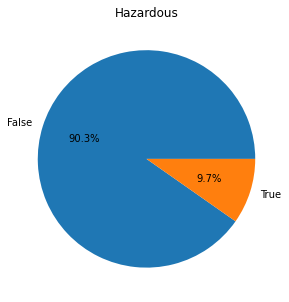

In [114]:
# useful for depicting proportional data with each slice of pie representing a
# specific category
fig, ax = plt.subplots(figsize=(5,5))
ax.pie(x=df.hazardous.value_counts(), 
       labels=df.hazardous.value_counts().index,
       autopct='%1.1f%%')
ax.set_title('Hazardous')
,

#### Histogram

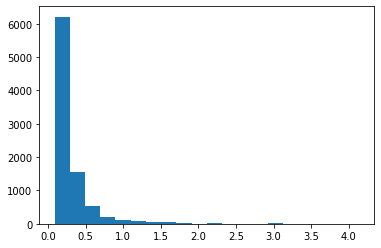

In [115]:
# useful for visualizing the distribution of the data
test = df[df['hazardous'] == True]
test.shape
testCol = test['est_diameter_min'].values
testCol
testHist = np.asarray(testCol, dtype='float')
plt.hist(testHist, bins = 20)
plt.show()

### Adjustments from Exploratory Data Analysis.

During Exploratory Data Analysis, I noticed some of the features are not relevant for the purposes of this project. That being said, we can remove some of them.

Take, for example, the id and name features. For an asteroid, id is its unique identifier and name is its name provided by NASA. These features will not influence whether or not an asteroid is hazardous. Thus, we can drop them.

In [116]:
df1 = df.drop(['id', 'name'], axis = 1)
df1.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


Next we notice the orbiting\_body feature. When we looked at the categorical columns, we noticed orbiting\_body had one unique value that appeared in 90836 instances. This unique value was Earth. It makes sense this appears for all 90836 rows of data as all of these potentially hazardous asteroids orbit Earth. Given this redundancy, we can drop the feature.

In [117]:
df2 = df1.drop(['orbiting_body'], axis = 1)
df2.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,sentry_object,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,False,16.73,False
1,0.265800,0.594347,73588.726663,6.143813e+07,False,20.00,True
2,0.722030,1.614507,114258.692129,4.979872e+07,False,17.83,False
3,0.096506,0.215794,24764.303138,2.543497e+07,False,22.20,False
4,0.255009,0.570217,42737.733765,4.627557e+07,False,20.09,True


There is a further feature we can drop, that being sentry\_object. When we look at the values for sentry\_object, we notice every answer it gives is false. True in this section means it is included in a sentry-automated collision monitoring system. Since all of these entries are marked False, there is no meaningful data we can glean from it. Thus, we can drop it.

In [118]:
df3 = df2.drop(['sentry_object'], axis = 1)
df3.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,False
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,True
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,False
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,False
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,True


I believe this dataset was a subset of a larger NASA dataset that included orbiting bodies (planets) other than Earth. Containing features like the orbiting\_body and the sentry\_object may not be relevant to matters purely revolving around Earth, but they would be pertinent in other situations in space. This would be why categories that seem irrelevant for my purposes still appear.

Now we observe how our features correlate with each other and with the target variable, hazardous:

''

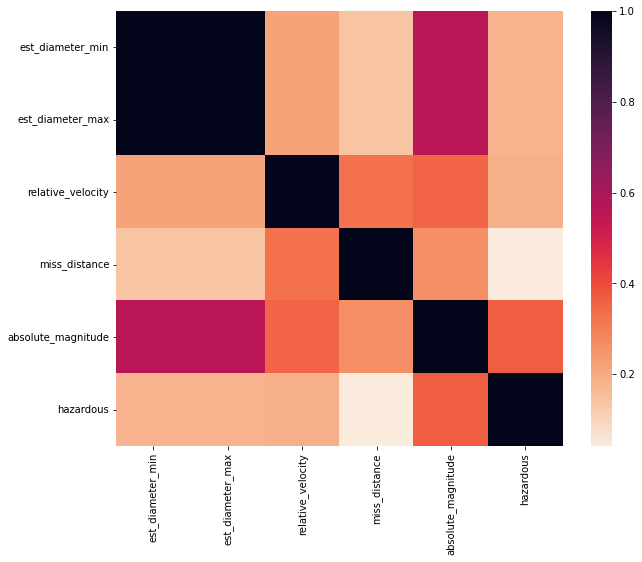

In [119]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df3.corr().abs(),annot=False, ax=ax, cmap='rocket_r')
,

In [120]:
# feature correlation with target variable
df3.corr()['hazardous'].sort_values(ascending=False)

hazardous             1.000000
relative_velocity     0.191185
est_diameter_max      0.183363
est_diameter_min      0.183363
miss_distance         0.042302
absolute_magnitude   -0.365267
Name: hazardous, dtype: float64

#### Oversampling to Counter Bias

We recognize how imbalanced the data is, approximately 90% non-hazardous and 10% hazardous. We must resolve this with oversampling. For our purposes, we will use SMOTE ([Synthetic Minority Over-sampling Technique](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)) to oversample.

In [121]:
# independent variables
X = df3.drop(['hazardous'], axis=1)

# dependent/target variable
y = df3.hazardous

X_resampled, y_resampled = SMOTE().fit_resample(X, y)

X

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09
...,...,...,...,...,...
90831,0.026580,0.059435,52078.886692,1.230039e+07,25.00
90832,0.016771,0.037501,46114.605073,5.432121e+07,26.00
90833,0.031956,0.071456,7566.807732,2.840077e+07,24.60
90834,0.007321,0.016370,69199.154484,6.869206e+07,27.80


In [122]:
y

0        False
1         True
2        False
3        False
4         True
         ...  
90831    False
90832    False
90833    False
90834    False
90835    False
Name: hazardous, Length: 90836, dtype: bool

In [123]:
y.value_counts()

False    81996
True      8840
Name: hazardous, dtype: int64

In [124]:
X_resampled

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
0,1.198271,2.679415,13569.249224,5.483974e+07,16.730000
1,0.265800,0.594347,73588.726663,6.143813e+07,20.000000
2,0.722030,1.614507,114258.692129,4.979872e+07,17.830000
3,0.096506,0.215794,24764.303138,2.543497e+07,22.200000
4,0.255009,0.570217,42737.733765,4.627557e+07,20.090000
...,...,...,...,...,...
163987,0.121098,0.270783,45777.537354,1.988474e+07,21.716985
163988,0.132144,0.295483,56772.231991,3.364944e+07,21.520832
163989,0.291447,0.651695,149641.817441,6.008054e+07,20.044334
163990,0.225351,0.503901,40862.612717,3.797934e+07,20.380502


In [125]:
y_resampled

0         False
1          True
2         False
3         False
4          True
          ...  
163987     True
163988     True
163989     True
163990     True
163991     True
Name: hazardous, Length: 163992, dtype: bool

In [126]:
# SMOTE oversampled to equalize the True and False examples
y_resampled.value_counts()

False    81996
True     81996
Name: hazardous, dtype: int64

#### Partitioning the Data

In [127]:
# divide data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)

In [128]:
X_train

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
161658,0.161932,0.362090,32109.598746,4.091774e+06,21.078520
46173,0.175612,0.392681,90392.437456,3.659290e+07,20.900000
124370,0.176824,0.395391,55612.213514,4.541202e+07,21.202415
109476,0.133455,0.298415,64758.891875,4.417737e+07,21.500754
106322,0.164469,0.367765,62829.236945,4.415967e+07,21.103693
...,...,...,...,...,...
119879,0.150641,0.336843,56174.870454,6.911262e+07,21.233575
103694,0.263046,0.588188,38232.658186,5.584383e+07,20.034432
131932,0.240523,0.537825,49406.527768,5.078771e+07,20.251889
146867,0.144751,0.323674,57207.390840,6.603116e+07,21.329456


In [129]:
X_train['miss_distance'].max()

74796547.23847735

In [130]:
X_train['miss_distance'].min()

6745.532515957

In [131]:
X_test.shape

(16400, 5)

In [132]:
y_train.shape

(147592,)

In [133]:
y_test.shape

(16400,)

#### Feature Scaling

In this step we scale features to appropriate values for this model to use. I initially used a Normalizer to scale the data between 0 and 1. When it did this, it normalized all of the values together. This meant features with larger values, such as miss_distance, dominated the normalization and unfairly skewed the data for features with smaller values, such as est_diameter_min and est_diameter_max.

This was resolved by using a [StandardScalar](https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler). It normalizes each feature individually such that each feature has μ = 0 (removed mean) and σ = 1 (unit variance). Doing this removes concerns of values in one feature influencing how other features' values are normalized.

In [134]:
# old approach
# scale the data between 0 and 1
# transformer = Normalizer(norm='max').fit(X_train)
# X_train = transformer.transform(X_train)
# X_test = transformer.transform(X_test)

# current approach
# normalize the data so each feature has μ = 0 and σ = 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [135]:
X_train

array([[-0.13373382, -0.13373382, -0.86752425, -1.56671594, -0.36665249],
       [-0.08616035, -0.08616035,  1.43361346, -0.07979675, -0.43093684],
       [-0.08194655, -0.08194655,  0.0604119 ,  0.32367598, -0.32203868],
       ...,
       [ 0.1395615 ,  0.1395615 , -0.18460254,  0.56961267, -0.66431874],
       [-0.19347749, -0.19347749,  0.12339309,  1.2669972 , -0.27629176],
       [ 1.03734157,  1.03734157,  0.2933544 ,  0.27683336, -1.24633423]])

In [136]:
X_train[:,3].max()

1.6680118334953222

In [137]:
X_train[:,3].min()

-1.753605070426833

In [138]:
X_test

array([[ 0.05444063,  0.05444063,  0.06452461, -0.05443451, -0.59148494],
       [-0.7447963 , -0.7447963 , -1.13876138, -1.39277011,  2.33340652],
       [ 0.33658048,  0.33658048, -0.62653319, -0.46408428, -0.81071211],
       ...,
       [ 0.91885472,  0.91885472, -0.01625343, -0.05243348, -1.00198585],
       [-0.22601303, -0.22601303,  0.63725163, -1.27157001, -0.26444333],
       [ 0.54562814,  0.54562814,  0.40980735, -0.48077543, -0.52324917]])

### Logistic Regression sklearn
This section uses the logistic regression function implemented in sklearn. This is purely for reference to what potential performance could be obtained.

In [139]:
# define the model
lrg = LogisticRegression(class_weight='balanced', random_state=0)

In [140]:
# train the model
lrg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=0)

In [141]:
# predict the result using the trained model
y_pred_lrg = lrg.predict(X_test)

In [142]:
# overall acuracy of the model
accuracy_score(y_test, y_pred_lrg)

0.8616463414634147

In [143]:
# f1 score of the model
f1_score(y_test, y_pred_lrg)

0.8729634398969822

In [144]:
y_train

161658     True
46173     False
124370     True
109476     True
106322     True
          ...  
119879     True
103694     True
131932     True
146867     True
121958     True
Name: hazardous, Length: 147592, dtype: bool

In [145]:
X_train.shape

(147592, 5)

In [146]:
X_train.shape[0]

147592

### Logistic Regression Implementation

In [147]:
def sigmoid(z):
  # activation function
  return 1 / (1 + np.exp(-1 * z))

In [148]:
def gradientDescent(X, Y, w, b, n):
  # calculate A, the cost function, and the partial derivatives
  A = sigmoid(np.dot(w.T,X.T) + b)
  minimum = 0.00000001
  # we clamp to prevent infinity from showing up in
  # gradient descent's early steps
  A = np.clip(A, minimum, 1 - minimum)
  cost = -1/n * np.sum(Y * np.log(A) + (1-Y) * (np.log(1-A)))
  dw = np.dot(X.T, (A-Y).T)/n
  db = np.sum(A-Y)/n
  return A, cost, dw, db

In [149]:
def gradDescend(dw, db, w, b):
  # standard update step
  # adjust default update learning rate here
  learning_rate = 0.01
  
  w = w - learning_rate * dw
  b = b - learning_rate * db
  return w, b

In [150]:
def adaGrad(dw, db, v_w, v_b, w, b):
  # Adagrad update step
  epsilon = 1e-8
  # adjust Adagrad learning rate here
  learning_rate = 0.01

  v_w = v_w + dw**2
  v_b = v_b + db**2

  w = w - (learning_rate / np.sqrt(v_w + epsilon)) * dw
  b = b - (learning_rate / np.sqrt(v_b + epsilon)) * db
  
  return w, b, v_w, v_b

In [151]:
def rmsProp(dw, db, v_w, v_b, w, b):
  # RMSprop update step
  epsilon = 1e-8
  beta = 0.9
  # adjust RMSprop learning rate here
  learning_rate = 0.01

  v_w = beta * v_w + (1 - beta) * dw**2
  v_b = beta * v_b + (1 - beta) * db**2

  w = w - (learning_rate / np.sqrt(v_w + epsilon)) * dw
  b = b - (learning_rate / np.sqrt(v_b + epsilon)) * db

  return w, b, v_w, v_b

In [152]:
def gradUpdate(X, y, w, b, n, t, listIters, listCost):
  # update user with information on recent information
  # prepare for updating
  A, cost, dw, db = gradientDescent(X, y, w, b, n)
  if t % 100 == 0:
    # collect iteration and cost for display in a line graph
    listIters.append(t)
    listCost.append(cost)
    print('Iteration: ', t, ', Cost: ', cost)
  return dw, db

In [153]:
def permutate(a1, a2):
  # Generates a shuffled combination of a1 and a2, which are two separate arrays 
  p = np.random.permutation(len(a2))
  return a1[p], a2[p]

In [192]:
def logisticRegression(X, y, gdType, opType):
  # calculate weights and bias based on aa linear model
  # wrapped in an activation function
  # set up key variables
  w = np.ones((X.shape[1],1))
  b = 0.0
  n = X.shape[0]
  t = 0
  max_t = 0
  if gdType == 1:
    # stochastic gradient descent
    max_t = 20000
  else:
    # batch gradient descent
    max_t = 4000
  listIters = []
  listCost = []
  m_w = 0.0
  m_b = 0.0
  v_w = 0.0
  v_b = 0.0

  while t <= max_t:
    # 1) Calculate the cost and the gradient for the current parameters.
    dw = 0.0
    db = 0.0

    if gdType == 0:
      # batch gradient descent
      dw, db = gradUpdate(X, y, w, b, n, t, listIters, listCost)
    elif gdType == 1:
      # stochastic gradient descent
      X_perm, y_perm = permutate(X, y)
      X_example = np.reshape(X_perm[0], (-1, 1))
      y_example = np.reshape(y_perm[0], (-1, 1))
      n = 1
      dw, db = gradUpdate(X_example.T, y_example, w, b, n, t, listIters,
                          listCost)
    
    # 2) Update the parameters using gradient descent rule for w and b.
    if opType == 0:
      # default update step
      w, b = gradDescend(dw, db, w, b)
    elif opType == 1:
      # Adagrad optimization algorithm
      w, b, v_w, v_b = adaGrad(dw, db, v_w, v_b, w, b)
    elif opType == 2:
      # RMSprop optimization algorithm
      w, b, v_w, v_b = rmsProp(dw, db, v_w, v_b, w, b)

    t += 1
  # show cost function plot
  plt.plot(listIters, listCost)
  plt.show()
  plt.close()
  return w, b

In [155]:
def predict(w, b, X):
  # use calculated weights and bias to predict labels for test dataset
  Yhat = (sigmoid(np.dot(w.T, X.T) + b)).T
  predictions = []
  for entry in Yhat:
    if entry <= 0.5:
      # asteroid is not hazardous
      predictions.append(0)
    elif entry > 0.5:
      # asteroid is hazardous
      predictions.append(1)
  
  predictArr = np.array(predictions)
  return predictArr

In [156]:
# convert to numpy-friendly format
y_train = y_train.to_numpy().astype(int)

In [157]:
# convert to numpy-friendly format
y_test = y_test.to_numpy().astype(int)

### Batch Gradient Descent

In [158]:
X_train.shape

(147592, 5)

In [159]:
y_train.shape

(147592,)

In [160]:
X_train

array([[-0.13373382, -0.13373382, -0.86752425, -1.56671594, -0.36665249],
       [-0.08616035, -0.08616035,  1.43361346, -0.07979675, -0.43093684],
       [-0.08194655, -0.08194655,  0.0604119 ,  0.32367598, -0.32203868],
       ...,
       [ 0.1395615 ,  0.1395615 , -0.18460254,  0.56961267, -0.66431874],
       [-0.19347749, -0.19347749,  0.12339309,  1.2669972 , -0.27629176],
       [ 1.03734157,  1.03734157,  0.2933544 ,  0.27683336, -1.24633423]])

In [161]:
kj, jk = permutate(X_train, y_train)

In [162]:
kj

array([[-0.52071957, -0.52071957,  0.89214091,  1.07780559,  0.54132087],
       [ 3.66437183,  3.66437183,  0.57030989,  1.59420561, -1.96756082],
       [ 1.04360291,  1.04360291, -0.86194918,  0.07537081, -0.66886884],
       ...,
       [ 0.36440115,  0.36440115, -0.50581238,  0.61943409, -0.86305137],
       [ 0.84442275,  0.84442275, -0.61274948, -0.0708779 , -1.15068183],
       [-0.20054412, -0.20054412, -0.45352436,  0.44681804, -0.25922209]])

In [163]:
y_train.shape[0]

147592

Iteration:  0 , Cost:  0.8684696126057012
Iteration:  100 , Cost:  0.7860814584466127
Iteration:  200 , Cost:  0.7229858165437804
Iteration:  300 , Cost:  0.675138977431102
Iteration:  400 , Cost:  0.6389841101445474
Iteration:  500 , Cost:  0.6115684420804196
Iteration:  600 , Cost:  0.5905817015252219
Iteration:  700 , Cost:  0.5742801670054205
Iteration:  800 , Cost:  0.5613848685029748
Iteration:  900 , Cost:  0.5509718082266092
Iteration:  1000 , Cost:  0.5423802003442835
Iteration:  1100 , Cost:  0.5351317015966286
Iteration:  1200 , Cost:  0.528889081503921
Iteration:  1300 , Cost:  0.5234082007686597
Iteration:  1400 , Cost:  0.5185082668868783
Iteration:  1500 , Cost:  0.5140512874144892
Iteration:  1600 , Cost:  0.5099390252915661
Iteration:  1700 , Cost:  0.506102421543801
Iteration:  1800 , Cost:  0.5024902034484111
Iteration:  1900 , Cost:  0.49905121747992287
Iteration:  2000 , Cost:  0.4957521988492838
Iteration:  2100 , Cost:  0.49257419198199154
Iteration:  2200 , Cost

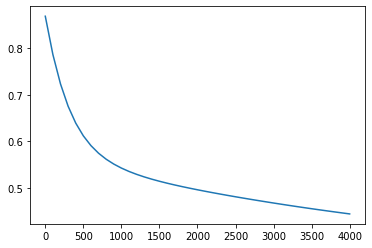

In [164]:
# train the model
w, b = logisticRegression(X_train, y_train, 0, 0)

In [165]:
# predict the result using the trained model
y_pred_lrg = predict(w, b, X_test)

In [166]:
# overall acuracy of the model
accuracy_score(y_test, y_pred_lrg)

0.8566463414634147

In [167]:
# f1 score of the model
f1_score(y_test, y_pred_lrg)

0.8670324076692495

### Stochastic Gradient Descent

In [168]:
X_train.shape

(147592, 5)

In [169]:
X_perm, y_perm = permutate(X_train, y_train)
X_example = np.reshape(X_perm[0], (-1, 1))
y_example = np.reshape(y_perm[0], (-1, 1))

In [170]:
X_example.shape

(5, 1)

Iteration:  0 , Cost:  0.19089795368053772
Iteration:  100 , Cost:  1.9081462781125158
Iteration:  200 , Cost:  1.7193880346338615
Iteration:  300 , Cost:  0.008841222431959218
Iteration:  400 , Cost:  0.6951887727904371
Iteration:  500 , Cost:  0.00044182850335515493
Iteration:  600 , Cost:  0.7449515539666287
Iteration:  700 , Cost:  0.2498945287461088
Iteration:  800 , Cost:  0.11092757698097527
Iteration:  900 , Cost:  0.40341954036518574
Iteration:  1000 , Cost:  0.4468234912990277
Iteration:  1100 , Cost:  0.14239286244877833
Iteration:  1200 , Cost:  0.7411183512868641
Iteration:  1300 , Cost:  0.09004580686825386
Iteration:  1400 , Cost:  0.6124455641736877
Iteration:  1500 , Cost:  0.3560606590456311
Iteration:  1600 , Cost:  0.8056428639572406
Iteration:  1700 , Cost:  0.7391255736945362
Iteration:  1800 , Cost:  0.022987194632980774
Iteration:  1900 , Cost:  0.4134065168393073
Iteration:  2000 , Cost:  0.6585333013136417
Iteration:  2100 , Cost:  0.31030400332830504
Iteratio

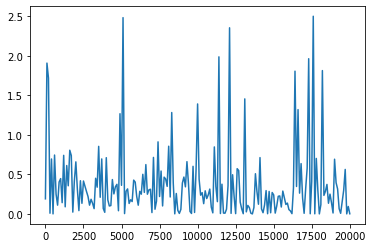

In [197]:
# train the model
w_sgd, b_sgd = logisticRegression(X_train, y_train, 1, 0)

In [201]:
# predict the result using the trained model
y_pred_lrg_sgd = predict(w_sgd, b_sgd, X_test)

In [202]:
# overall acuracy of the model
accuracy_score(y_test, y_pred_lrg_sgd)

0.863109756097561

In [203]:
# f1 score of the model
f1_score(y_test, y_pred_lrg_sgd)

0.8756025932287915

### Optimization Algorithms

When implementing Adagrad and RMSprop, I used a [Towards Data Science](https://towardsdatascience.com/learning-parameters-part-5-65a2f3583f7d) article on learning parameters to help write these functions. These are both implemented to work with batch gradient descent.

#### Adagrad

Iteration:  0 , Cost:  0.8684696126057012
Iteration:  100 , Cost:  0.7722109266275101
Iteration:  200 , Cost:  0.7384554996130844
Iteration:  300 , Cost:  0.7158093770277051
Iteration:  400 , Cost:  0.6987205387383004
Iteration:  500 , Cost:  0.6850483375406382
Iteration:  600 , Cost:  0.6736975705622538
Iteration:  700 , Cost:  0.6640309938584633
Iteration:  800 , Cost:  0.6556360503172586
Iteration:  900 , Cost:  0.6482319519663171
Iteration:  1000 , Cost:  0.6416177935491248
Iteration:  1100 , Cost:  0.6356457855330778
Iteration:  1200 , Cost:  0.6302050451910354
Iteration:  1300 , Cost:  0.6252076992251357
Iteration:  1400 , Cost:  0.6205875738521611
Iteration:  1500 , Cost:  0.6162919181549592
Iteration:  1600 , Cost:  0.6122758949203365
Iteration:  1700 , Cost:  0.6085054144619768
Iteration:  1800 , Cost:  0.6049515036999497
Iteration:  1900 , Cost:  0.6015882342021597
Iteration:  2000 , Cost:  0.5983980510134498
Iteration:  2100 , Cost:  0.5953589256018341
Iteration:  2200 , Cos

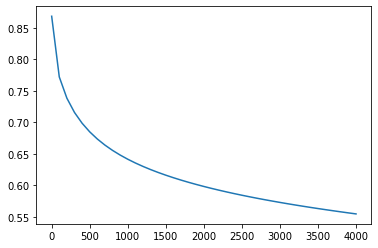

In [175]:
# train the model
w_lrg_adag, b_lrg_adag = logisticRegression(X_train, y_train, 0, 1)

In [176]:
# predict the result using the trained model
y_pred_lrg_adag = predict(w_lrg_adag, b_lrg_adag, X_test)

In [177]:
# overall acuracy of the model
accuracy_score(y_test, y_pred_lrg_adag)

0.7777439024390244

In [178]:
# f1 score of the model
f1_score(y_test, y_pred_lrg_adag)

0.7680559974546612

#### RMSprop

Iteration:  0 , Cost:  0.8684696126057012
Iteration:  100 , Cost:  0.5592992072958942
Iteration:  200 , Cost:  0.46836031163856223
Iteration:  300 , Cost:  0.41458516177825666
Iteration:  400 , Cost:  0.3907930826644459
Iteration:  500 , Cost:  0.3837721860438979
Iteration:  600 , Cost:  0.38347964713894794
Iteration:  700 , Cost:  0.38347964703498055
Iteration:  800 , Cost:  0.3834796470358068
Iteration:  900 , Cost:  0.3834796470358071
Iteration:  1000 , Cost:  0.383479647035807
Iteration:  1100 , Cost:  0.38347964703580695
Iteration:  1200 , Cost:  0.38347964703580695
Iteration:  1300 , Cost:  0.38347964703580695
Iteration:  1400 , Cost:  0.38347964703580695
Iteration:  1500 , Cost:  0.383479647035807
Iteration:  1600 , Cost:  0.38347964703580695
Iteration:  1700 , Cost:  0.38347964703580695
Iteration:  1800 , Cost:  0.38347964703580695
Iteration:  1900 , Cost:  0.383479647035807
Iteration:  2000 , Cost:  0.38347964703580695
Iteration:  2100 , Cost:  0.383479647035807
Iteration:  22

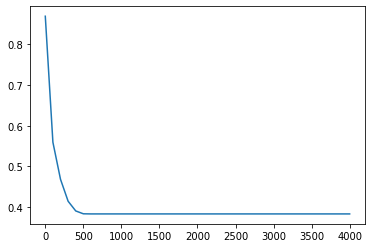

In [179]:
# train the model
w_lrg_rmsp, b_lrg_rmsp = logisticRegression(X_train, y_train, 0, 2)

In [180]:
# predict the result using the trained model
y_pred_lrg_rmsp = predict(w_lrg_rmsp, b_lrg_rmsp, X_test)

In [181]:
# overall acuracy of the model
accuracy_score(y_test, y_pred_lrg_rmsp)

0.8619512195121951

In [182]:
# f1 score of the model
f1_score(y_test, y_pred_lrg_rmsp)

0.8733497426717387

### Conclusion

To keep the playing field even, I ran the default update, the Adagrad update, and the RMSprop update at the same learning rate, that being 0.01. I chose this because I tend to use a learning rate of 0.1, but the [gradient descent paper](https://arxiv.org/pdf/1609.04747.pdf) recommended using learning rates of 0.01 and 0.001 for Adagrad and RMSprop respectively. 0.01 was in the middle of these values, and I wanted to try it in this scenario. To give these algorithms time to converge, I ran them for 4000 epochs each. Below are the recorded results.

| **Update** | **Accuracy Score** | **F1 Score** |
|------------|--------------------|--------------|
| Original   | 0.85664            | 0.86703      |
| Adagrad    | 0.77774            | 0.76806      |
| RMSprop    | 0.86195            | 0.87335      |

Adagrad adapts its learning rate to the parameters. Larger updates are performed for infrequent parameters, and smaller updates are performed for frequent parameters. This is what makes it work well with sparse data. It left me curious as to how well it would perform on abundant data. Of the three, this algorithm performs the worst in accuracy and f1 scores. I believe this is due to the weakness mentioned in the paper - accumulating squared digits in the denominator. We can glean this from how its slope tapers off in a similar manner to the original implementation, but it does so at an greater cost value. Its learning rate becomes too small and has little impact on updates.

On the contrary, RMSprop performs the best of the three in accuracy and f1 score. It is clear why the book recommends a learning rate of 0.001 as at rate 0.01, it finds its minimum - the lowest of the three - in under 1000 epochs. RMSprop was intended to resolve Adagrad's diminishing learning rate problem while still featuring an adaptive learning rate.

The original implementation of gradient descent sits between these optimizations. The original implementation's line resembles that of Adagrad tapering off, but it ends with a lower minimum than Adagrad within 4000 epochs. This demonstrates how poorly Adagrad performs as an optimization when working with non-sparse data. 

Generally, we would want to use optimization algorithms because they allow us to find the minimum more efficiently. RMSprop demonstrates what can go right with optimization algorithms. Considering how there are over 160000 examples to sift through after oversampling, we need to move through it as efficiently as possible. An adaptive learning rate aids in quickly finding a minimum from this wealth of data, which grants us more accurate answers in less time.

That said, we must choose the right algorithm for a situation. Adagrad performing worse than the original gradient descent demonstrates what can go wrong. We found it was not suited for this application. It is then clear that RMSprop is the better optimization algorithm for this scenario.